# Original dataset modeling

## Import packages and data

In [1]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import glob
import os
from os import listdir
from pathlib import Path

from skimage.io import imread
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import cv2

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import models, layers, optimizers, regularizers
from tensorflow.keras import activations
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split

from keras.models import load_model

import datetime
from tqdm import tqdm

from tensorflow.random import set_seed
set_seed(13)

In [2]:
train_df = pd.read_csv(r'C:\Users\18016\Downloads\train\.csv')
train_df.head()

,image_id,center_id,patient_id,image_num,label
0,006388_0,11,006388,0,CE
1,008e5c_0,11,008e5c,0,CE
2,00c058_0,11,00c058,0,LAA
3,01adc5_0,11,01adc5,0,LAA
4,026c97_0,4,026c97,0,CE


In [3]:
train_path = r"C:\\Users\\18016\\Downloads\\train\\"
train_df["file_path"] = train_df["image_id"].apply(lambda x: train_path + x + ".tif")
train_df.head()

,image_id,center_id,patient_id,image_num,label,file_path
0,006388_0,11,006388,0,CE,C:\\Users\\18016\\Downloads\\train\\006388_0.tif
1,008e5c_0,11,008e5c,0,CE,C:\\Users\\18016\\Downloads\\train\\008e5c_0.tif
2,00c058_0,11,00c058,0,LAA,C:\\Users\\18016\\Downloads\\train\\00c058_0.tif
3,01adc5_0,11,01adc5,0,LAA,C:\\Users\\18016\\Downloads\\train\\01adc5_0.tif
4,026c97_0,4,026c97,0,CE,C:\\Users\\18016\\Downloads\\train\\026c97_0.tif


Add openslide path for bin file. Need to add the dll directory file in so OpenSlide builds necessary references.

In [4]:
OPENSLIDE_PATH = r'C:\Users\18016\Desktop\openslide-win64-20220811\bin'

if hasattr(os, 'add_dll_directory'):
    # Python >= 3.8 on Windows
    with os.add_dll_directory(OPENSLIDE_PATH):
        import openslide
else:
    import openslide

In [5]:
from openslide import OpenSlide

## Preview some images

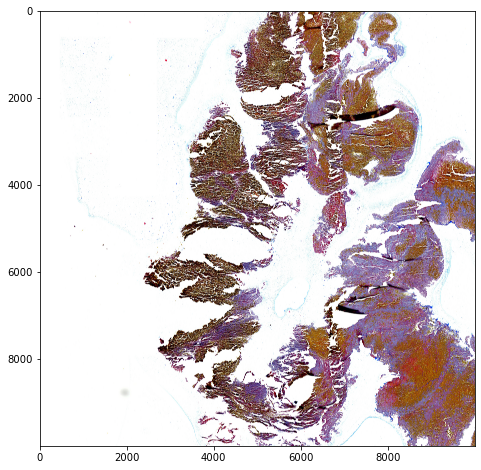

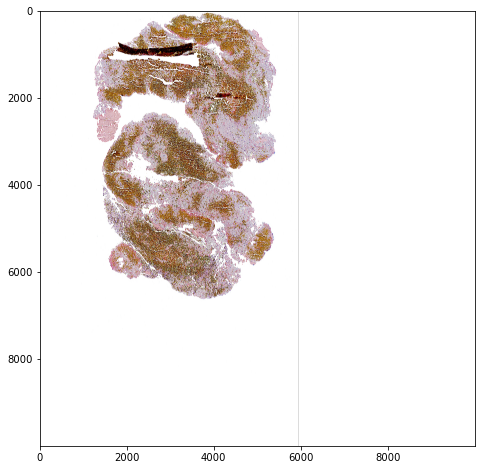

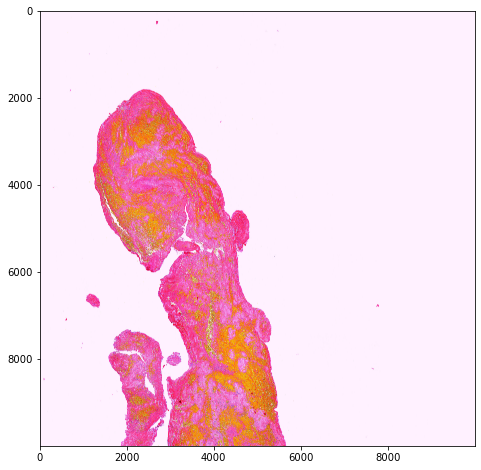

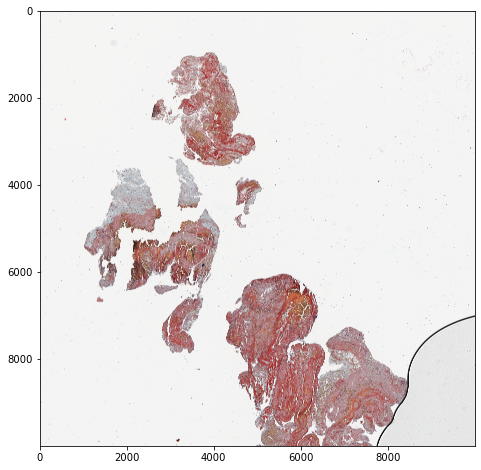

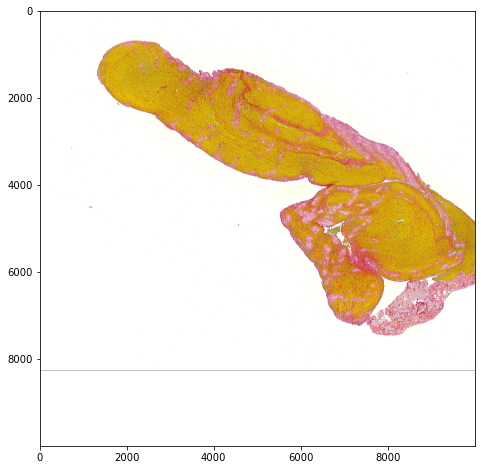

In [6]:
sample_train = train_df[:5]

for i in range(5):
    slide = OpenSlide(sample_train.loc[i, "file_path"])
    region = (0, 0)
    size = (10000, 10000)
    region = slide.read_region(region, 0, size)
    plt.figure(figsize=(8, 8))
    plt.imshow(region)
    plt.show()

I wonder if those dark black bands are any indication of a cardioembolic stroke? Also, what are these dark black bands?<br> The bottom right corner of the last image (LAA type) is interesting as well- does that indicate some issue with how the clot was scanned?<br> I'm interested in if the center in which the image was taken could be a significant attribute in modeling...

## Clean the dataset

In the STRIP.ipynb notebook, it is noted that there are several images that are blurry and could corrupt future predictions. I will remove these images from this dataset.

In [7]:
# remove following ids from train_df:
# b894f4_0, 6baf51_0, 7b9aaa_0, 5adc4c_0, bb06a5_0, and e26a04_0
train_df = train_df[(train_df.image_id != 'b894f4_0') & 
                     (train_df.image_id != '6baf51_0') & 
                     (train_df.image_id != '7b9aaa_0') &
                     (train_df.image_id != '5adc4c_0') & 
                     (train_df.image_id != 'bb06a5_0') & 
                     (train_df.image_id != 'e26a04_0')]

# also, reset the index of train_df
train_df = train_df.reset_index(drop=True)

# check changes
train_df

,image_id,center_id,patient_id,image_num,label,file_path
0,006388_0,11,006388,0,CE,C:\\Users\\18016\\Downloads\\train\\006388_0.tif
1,008e5c_0,11,008e5c,0,CE,C:\\Users\\18016\\Downloads\\train\\008e5c_0.tif
2,00c058_0,11,00c058,0,LAA,C:\\Users\\18016\\Downloads\\train\\00c058_0.tif
3,01adc5_0,11,01adc5,0,LAA,C:\\Users\\18016\\Downloads\\train\\01adc5_0.tif
4,026c97_0,4,026c97,0,CE,C:\\Users\\18016\\Downloads\\train\\026c97_0.tif
...,...,...,...,...,...,...
743,fe9645_0,3,fe9645,0,CE,C:\\Users\\18016\\Downloads\\train\\fe9645_0.tif
744,fe9bec_0,4,fe9bec,0,LAA,C:\\Users\\18016\\Downloads\\train\\fe9bec_0.tif
745,ff14e0_0,6,ff14e0,0,CE,C:\\Users\\18016\\Downloads\\train\\ff14e0_0.tif
746,ffec5c_0,7,ffec5c,0,LAA,C:\\Users\\18016\\Downloads\\train\\ffec5c_0.tif


Looks good. 748 items is the amount I should have.

## Image transformations

Preprocessing the images because they are very large. Resizing to 512x512 pixels to try to avoid running out of memory. <br> Also converting images to 3 channels and converting to image array to avoiding OOM.

In [8]:
def preprocess(image_path):
    slide = OpenSlide(image_path)     # create OpenSlide image object
    region = (0, 0)     # start at bottom left corner
    size = (10000, 10000)     # size is square 10kx10k pixels starting from 0
    image = slide.read_region(region, 0, size)     # read image with params
    image = image.resize(size=(512,512)).convert('RGB')     # resizing to 512x512
    image_arr = np.array(image)    # convert image to array
    return image_arr

In [9]:
# apply function to images

# create copy of train_df to apply changes to
tdf = train_df.copy()
image_arrays = []

for i in tqdm(tdf['file_path']):
    img_a = preprocess(i)
    image_arrays.append(img_a)
    
tdf['img_arr'] = image_arrays

tdf.head()

100%|██████████| 748/748 [40:05<00:00,  3.22s/it]


,image_id,center_id,patient_id,image_num,label,file_path,img_arr
0,006388_0,11,006388,0,CE,C:\\Users\\18016\\Downloads\\train\\006388_0.tif,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
1,008e5c_0,11,008e5c,0,CE,C:\\Users\\18016\\Downloads\\train\\008e5c_0.tif,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
2,00c058_0,11,00c058,0,LAA,C:\\Users\\18016\\Downloads\\train\\00c058_0.tif,"[[[255, 241, 255], [255, 241, 255], [255, 241,..."
3,01adc5_0,11,01adc5,0,LAA,C:\\Users\\18016\\Downloads\\train\\01adc5_0.tif,"[[[246, 246, 244], [245, 246, 244], [246, 246,..."
4,026c97_0,4,026c97,0,CE,C:\\Users\\18016\\Downloads\\train\\026c97_0.tif,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


In [10]:
# use a simple kind of ImageDataGenerator
permutes = ImageDataGenerator(
    shear_range = 0.2,     # this distorts the image along an axis
    zoom_range = 0.1,     # range for random zoom
    horizontal_flip = True     # random horizontal flip
)

## Train-test split

In [11]:
# also make a target column because I will need int labels for modeling

# 0 - CE & 1 - LAA
tdf["target"] = tdf["label"].apply(lambda x : 0 if x=="CE" else 1)

In [12]:
df_tt = tdf.copy()
train, test = train_test_split(df_tt, test_size=0.2, random_state=42, 
                               shuffle=True)

train

,image_id,center_id,patient_id,image_num,label,file_path,img_arr,target
593,d2c18a_0,11,d2c18a,0,LAA,C:\\Users\\18016\\Downloads\\train\\d2c18a_0.tif,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",1
131,2b7304_1,3,2b7304,1,LAA,C:\\Users\\18016\\Downloads\\train\\2b7304_1.tif,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",1
44,0d4164_0,11,0d4164,0,CE,C:\\Users\\18016\\Downloads\\train\\0d4164_0.tif,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0
70,15de51_0,4,15de51,0,LAA,C:\\Users\\18016\\Downloads\\train\\15de51_0.tif,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",1
670,e9c181_0,10,e9c181,0,CE,C:\\Users\\18016\\Downloads\\train\\e9c181_0.tif,"[[[255, 250, 255], [255, 250, 255], [255, 250,...",0
...,...,...,...,...,...,...,...,...
71,162cad_0,11,162cad,0,LAA,C:\\Users\\18016\\Downloads\\train\\162cad_0.tif,"[[[255, 241, 255], [255, 241, 255], [255, 241,...",1
106,23d2c1_1,7,23d2c1,1,CE,C:\\Users\\18016\\Downloads\\train\\23d2c1_1.tif,"[[[234, 216, 254], [234, 216, 254], [234, 216,...",0
270,56d177_2,7,56d177,2,CE,C:\\Users\\18016\\Downloads\\train\\56d177_2.tif,"[[[234, 216, 254], [234, 216, 254], [234, 216,...",0
435,91fee7_0,8,91fee7,0,CE,C:\\Users\\18016\\Downloads\\train\\91fee7_0.tif,"[[[255, 241, 255], [255, 241, 255], [255, 241,...",0


Ensure split worked...

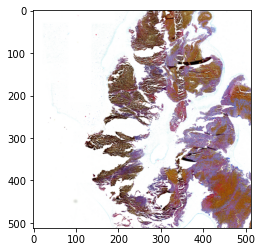

In [14]:
plt.imshow(train.img_arr[0])
plt.show()

# Modeling

## Helper function for evaluation

Print out loss, RMSE, MAE, plots for these metrics, confusion matrix, and classification report. 

In [15]:
def evaluate_model(history, model, test):
  # print loss and accuracy of the model on the test set
    test_loss, test_rmse, test_mae = history.model.evaluate(
      x=np.array(test['img_arr'].to_list()), 
      y=test['target']
    )
    print(f'Test Loss: {test_loss}')
    print(f'Test RMSE: {test_rmse}')
    print(f'Test MAE: {test_mae}')

    # create plots for accuracy and loss
    fig, ax = plt.subplots(1, 2, figsize = (12,8))
    ax[0].plot(history.history['rmse'])
    ax[0].plot(history.history['val_rmse'])
    ax[0].set_title('Model RMSE')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('RMSE')
    ax[0].legend(['Train', 'Test'], loc='upper left')

    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend(['Train', 'Test'], loc='upper left')

    plt.show()

    # plot confusion matrix - create predictions for the model
    y_hat_tmp = history.model.predict(
        x=np.array(test['img_arr'].to_list())
    )

    # classify y_hat as either 0 or 1 based on if val is < or >= to 0.5
    thresh = 0.5
    y_hat = (y_hat_tmp > thresh).astype(np.int)     # cast 0 or 1 to y_hat values
    y_t = test.target.astype(int)
    cm_vals = confusion_matrix(y_t, y_hat)     # get confusion matrix values

    # plot confusion matrix values
    sns.heatmap(
      cm_vals, 
      annot=True, 
      cmap='Blues', 
      fmt='0.5g'
    )
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.title('Baseline Model Confusion Matrix')
    plt.show()

    # display classification report
    print(classification_report(y_t, y_hat))

## Baseline model

### Define Callbacks

In [16]:
# Going to use EarlyStopping Callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# Instantiate ModelCheckpoint Callback
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', 
                     save_best_only=True)

### Create and fit the model

Build out simple model.

In [17]:
model = models.Sequential()
input_shape = (512, 512, 3)

model.add(Conv2D(filters=32, kernel_size = (3,3), strides =2, padding = 'same', activation = 'relu', input_shape = input_shape))
model.add(Conv2D(filters=64, kernel_size = (3,3), strides =2, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters=32, kernel_size = (3,3), strides =2, padding = 'same', activation = 'relu'))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))

model.add(Dense(1))

model.compile(
    loss = tf.keras.losses.MeanSquaredError(),    
    metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse"), 'mae'],
    optimizer = tf.keras.optimizers.Adam(1e-3)
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 128)               16777344  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

In [20]:
history = model.fit(
    x=np.array(train['img_arr'].to_list()),
    y=train['target'],
    batch_size=16,
    epochs=50,
    callbacks=[es, mc],
    validation_data=(np.array(test['img_arr'].to_list()), test['target'])
)

Epoch 1/50
38/38 [==============================] - 12s 301ms/step - loss: 552567.2500 - rmse: 743.3487 - mae: 141.5064 - val_loss: 0.7953 - val_rmse: 0.8918 - val_mae: 0.5304
Epoch 2/50
38/38 [==============================] - 12s 311ms/step - loss: 2.0246 - rmse: 1.4229 - mae: 0.6359 - val_loss: 0.8335 - val_rmse: 0.9130 - val_mae: 0.4881
Epoch 3/50
38/38 [==============================] - 12s 315ms/step - loss: 1.2261 - rmse: 1.1073 - mae: 0.5005 - val_loss: 0.8858 - val_rmse: 0.9412 - val_mae: 0.4833
Epoch 4/50
38/38 [==============================] - 12s 313ms/step - loss: 0.8659 - rmse: 0.9305 - mae: 0.4391 - val_loss: 0.7470 - val_rmse: 0.8643 - val_mae: 0.4774
Epoch 5/50
38/38 [==============================] - 12s 311ms/step - loss: 0.5919 - rmse: 0.7694 - mae: 0.3891 - val_loss: 0.7097 - val_rmse: 0.8424 - val_mae: 0.4585
Epoch 6/50
38/38 [==============================] - 12s 314ms/step - loss: 0.3499 - rmse: 0.5915 - mae: 0.3418 - val_loss: 0.5757 - val_rmse: 0.7588 - val_m

### Evaluate the model

5/5 [==============================] - 0s 93ms/step - loss: 0.2463 - rmse: 0.4963 - mae: 0.3749
Test Loss: 0.24626685678958893
Test RMSE: 0.49625280499458313
Test MAE: 0.3749437630176544


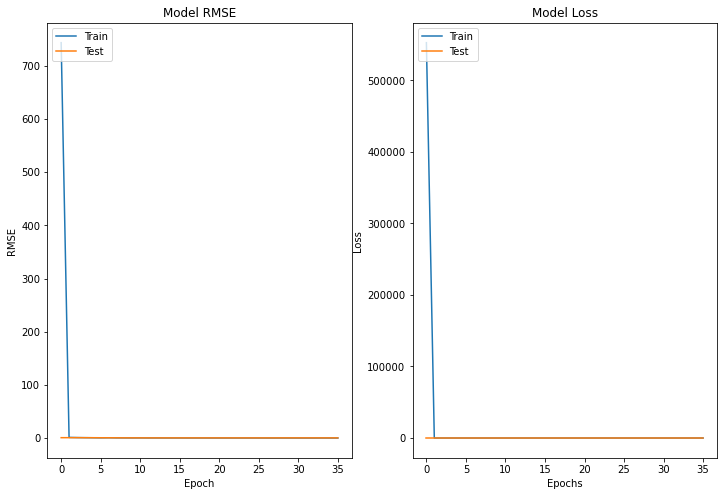

5/5 [==============================] - 1s 91ms/step


<ipython-input-15-9e032a6d7b88>:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_hat = (y_hat_tmp > thresh).astype(np.int)     # cast 0 or 1 to y_hat values


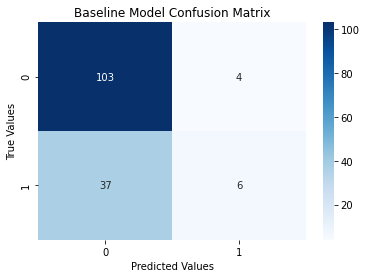

              precision    recall  f1-score   support

           0       0.74      0.96      0.83       107
           1       0.60      0.14      0.23        43

    accuracy                           0.73       150
   macro avg       0.67      0.55      0.53       150
weighted avg       0.70      0.73      0.66       150



In [21]:
evaluate_model(history, model, test)

Plots for RMSE and loss are not particularly helpful because of the extremely high values on the first model epoch, but I will not choose to correct these failures at the moment because the model did not perform well anyways... like other models so far, this model is almost always choosing CE category. It seems like no signal is detected in this model.

## Dropout regularization

Goal for this model is to try some overfitting reduction strategies.

### Create and fit the model

In [22]:
model = models.Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',
                    input_shape=(512, 512, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# add dropout regularization
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(1))

# Compile the model
model.compile(
    loss = tf.keras.losses.MeanSquaredError(),    
    metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse"), 'mae'],
    optimizer = tf.keras.optimizers.Adam(1e-3)
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 510, 510, 32)      896       
                                                                 
 conv2d_4 (Conv2D)           (None, 508, 508, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 254, 254, 32)     0         
 )                                                               
                                                                 
 conv2d_5 (Conv2D)           (None, 252, 252, 32)      9248      
                                                                 
 conv2d_6 (Conv2D)           (None, 250, 250, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 125, 125, 32)     0         
 2D)                                                  

In [23]:
history = model.fit(
    x=np.array(train['img_arr'].to_list()),
    y=train['target'],
    batch_size=64,
    epochs=50,
    callbacks=[es, mc],
    validation_data=(np.array(test['img_arr'].to_list()), test['target'])
)

Epoch 1/50
10/10 [==============================] - 111s 11s/step - loss: 47252.4141 - rmse: 217.3762 - mae: 74.6149 - val_loss: 0.4145 - val_rmse: 0.6438 - val_mae: 0.4475
Epoch 2/50
10/10 [==============================] - 105s 10s/step - loss: 0.4931 - rmse: 0.7022 - mae: 0.4832 - val_loss: 0.3114 - val_rmse: 0.5580 - val_mae: 0.3234
Epoch 3/50
10/10 [==============================] - 102s 10s/step - loss: 0.4758 - rmse: 0.6898 - mae: 0.4293 - val_loss: 0.3151 - val_rmse: 0.5614 - val_mae: 0.3309
Epoch 4/50
10/10 [==============================] - 101s 10s/step - loss: 0.2919 - rmse: 0.5403 - mae: 0.3144 - val_loss: 0.3082 - val_rmse: 0.5552 - val_mae: 0.3262
Epoch 5/50
10/10 [==============================] - 102s 10s/step - loss: 0.2857 - rmse: 0.5345 - mae: 0.3051 - val_loss: 0.3049 - val_rmse: 0.5522 - val_mae: 0.3149
Epoch 6/50
10/10 [==============================] - 102s 10s/step - loss: 0.2796 - rmse: 0.5287 - mae: 0.2956 - val_loss: 0.2935 - val_rmse: 0.5417 - val_mae: 0.30

### Evaluate the model

5/5 [==============================] - 4s 759ms/step - loss: 0.2146 - rmse: 0.4632 - mae: 0.3982
Test Loss: 0.21459396183490753
Test RMSE: 0.46324288845062256
Test MAE: 0.3981868028640747


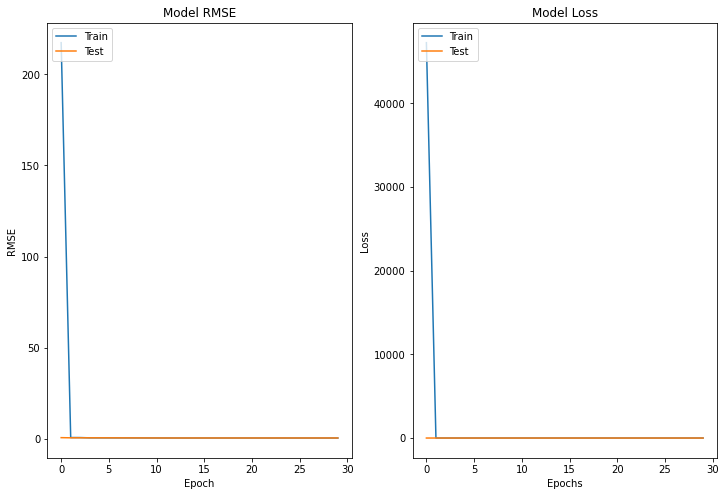

5/5 [==============================] - 4s 769ms/step


<ipython-input-15-9e032a6d7b88>:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_hat = (y_hat_tmp > thresh).astype(np.int)     # cast 0 or 1 to y_hat values


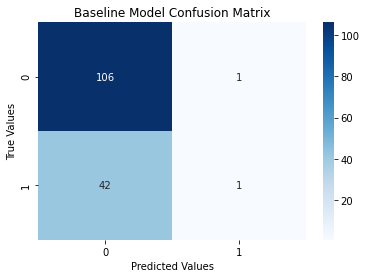

              precision    recall  f1-score   support

           0       0.72      0.99      0.83       107
           1       0.50      0.02      0.04        43

    accuracy                           0.71       150
   macro avg       0.61      0.51      0.44       150
weighted avg       0.65      0.71      0.61       150



In [24]:
evaluate_model(history, model, test)

Model again seems to not have done anything useful.

## EfficientNet model

In [30]:
import keras.applications
from tensorflow.keras.applications import EfficientNetB0     # 224x224
from tensorflow.keras.applications import EfficientNetB7     # 600x600

Probably will not use EffNetB7 because of OOM issues.

### Image transformations

Need to preprocess the images as 224x224 for EfficientNetB7

In [39]:
def preprocess(image_path):
    slide = OpenSlide(image_path)     # create OpenSlide image object
    region = (0, 0)     # start at bottom left corner
    size = (10000, 10000)     # size is square 10kx10k pixels starting from 0
    image = slide.read_region(region, 0, size)     # read image with params
    image = image.resize(size=(224,224)).convert('RGB')     # resizing to 512x512
    image_arr = np.array(image)    # convert image to array
    return image_arr

Function will convert images to 3 channels and resize to 224x224 px. Then converts images to arrays to avoid OOM.

In [40]:
# apply function to images

# create copy of train_df to apply changes to
tdf2 = train_df.copy()
image_arrays2 = []

for i in tqdm(tdf['file_path']):
    img_a = preprocess(i)
    image_arrays2.append(img_a)
    
tdf2['img_arr'] = image_arrays2

tdf2.head()

100%|██████████| 748/748 [39:40<00:00,  3.18s/it]


,image_id,center_id,patient_id,image_num,label,file_path,img_arr
0,006388_0,11,006388,0,CE,C:\\Users\\18016\\Downloads\\train\\006388_0.tif,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
1,008e5c_0,11,008e5c,0,CE,C:\\Users\\18016\\Downloads\\train\\008e5c_0.tif,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
2,00c058_0,11,00c058,0,LAA,C:\\Users\\18016\\Downloads\\train\\00c058_0.tif,"[[[255, 241, 255], [255, 241, 255], [255, 241,..."
3,01adc5_0,11,01adc5,0,LAA,C:\\Users\\18016\\Downloads\\train\\01adc5_0.tif,"[[[246, 246, 244], [246, 246, 244], [246, 246,..."
4,026c97_0,4,026c97,0,CE,C:\\Users\\18016\\Downloads\\train\\026c97_0.tif,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


It does take quite some time to convert the images to arrays.

### Train-test split

In [41]:
# also make a target column because I will need int labels for modeling

# 0 - CE & 1 - LAA
tdf2["target"] = tdf2["label"].apply(lambda x : 0 if x=="CE" else 1)

df_tt2 = tdf2.copy()
train, test = train_test_split(df_tt2, test_size=0.2, random_state=42, 
                               shuffle=True)

train

,image_id,center_id,patient_id,image_num,label,file_path,img_arr,target
593,d2c18a_0,11,d2c18a,0,LAA,C:\\Users\\18016\\Downloads\\train\\d2c18a_0.tif,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",1
131,2b7304_1,3,2b7304,1,LAA,C:\\Users\\18016\\Downloads\\train\\2b7304_1.tif,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",1
44,0d4164_0,11,0d4164,0,CE,C:\\Users\\18016\\Downloads\\train\\0d4164_0.tif,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0
70,15de51_0,4,15de51,0,LAA,C:\\Users\\18016\\Downloads\\train\\15de51_0.tif,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",1
670,e9c181_0,10,e9c181,0,CE,C:\\Users\\18016\\Downloads\\train\\e9c181_0.tif,"[[[255, 250, 255], [255, 250, 255], [255, 250,...",0
...,...,...,...,...,...,...,...,...
71,162cad_0,11,162cad,0,LAA,C:\\Users\\18016\\Downloads\\train\\162cad_0.tif,"[[[255, 241, 255], [255, 241, 255], [255, 241,...",1
106,23d2c1_1,7,23d2c1,1,CE,C:\\Users\\18016\\Downloads\\train\\23d2c1_1.tif,"[[[234, 216, 254], [234, 216, 254], [234, 216,...",0
270,56d177_2,7,56d177,2,CE,C:\\Users\\18016\\Downloads\\train\\56d177_2.tif,"[[[234, 216, 254], [234, 216, 254], [234, 216,...",0
435,91fee7_0,8,91fee7,0,CE,C:\\Users\\18016\\Downloads\\train\\91fee7_0.tif,"[[[255, 241, 255], [255, 241, 255], [255, 241,...",0


### Create and fit the model

In [42]:
efficient_net = EfficientNetB0(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False,
    pooling='max',
    classes=2
)

model = models.Sequential()
model.add(efficient_net)
model.add(Dense(units=112, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=224, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(1))

import tensorflow as tf

model.compile(
    loss = tf.keras.losses.MeanSquaredError(),    
    metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse"), 'mae'],
    optimizer = tf.keras.optimizers.Adam(1e-6)
)

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dense_17 (Dense)            (None, 112)               143472    
                                                                 
 dropout_11 (Dropout)        (None, 112)               0         
                                                                 
 dense_18 (Dense)            (None, 224)               25312     
                                                                 
 dropout_12 (Dropout)        (None, 224)               0         
                                                                 
 dense_19 (Dense)            (None, 1)                 225       
                                                                 
Total params: 4,218,580
Trainable params: 4,176,557
No

In [43]:
history = model.fit(
    x=np.array(train['img_arr'].to_list()),
    y=train['target'],
    batch_size=64,
    epochs=50,
    callbacks=[es, mc],
    validation_data=(np.array(test['img_arr'].to_list()), test['target'])
)

Epoch 1/50
10/10 [==============================] - 52s 4s/step - loss: 13.4219 - rmse: 3.6636 - mae: 2.8338 - val_loss: 1.6606 - val_rmse: 1.2886 - val_mae: 0.9987
Epoch 2/50
10/10 [==============================] - 41s 4s/step - loss: 13.0962 - rmse: 3.6189 - mae: 2.7598 - val_loss: 1.8304 - val_rmse: 1.3529 - val_mae: 1.0307
Epoch 3/50
10/10 [==============================] - 41s 4s/step - loss: 13.5720 - rmse: 3.6840 - mae: 2.8634 - val_loss: 2.0567 - val_rmse: 1.4341 - val_mae: 1.0912
Epoch 4/50
10/10 [==============================] - 41s 4s/step - loss: 12.4378 - rmse: 3.5267 - mae: 2.7918 - val_loss: 2.2805 - val_rmse: 1.5101 - val_mae: 1.1719
Epoch 5/50
10/10 [==============================] - 41s 4s/step - loss: 12.7238 - rmse: 3.5670 - mae: 2.7123 - val_loss: 2.5873 - val_rmse: 1.6085 - val_mae: 1.2437
Epoch 6/50
10/10 [==============================] - 41s 4s/step - loss: 11.8106 - rmse: 3.4367 - mae: 2.7089 - val_loss: 2.8288 - val_rmse: 1.6819 - val_mae: 1.2994
Epoch 7/50

### Evaluate the model

5/5 [==============================] - 2s 447ms/step - loss: 3.1942 - rmse: 1.7872 - mae: 1.3801
Test Loss: 3.1942107677459717
Test RMSE: 1.7872354984283447
Test MAE: 1.3801437616348267


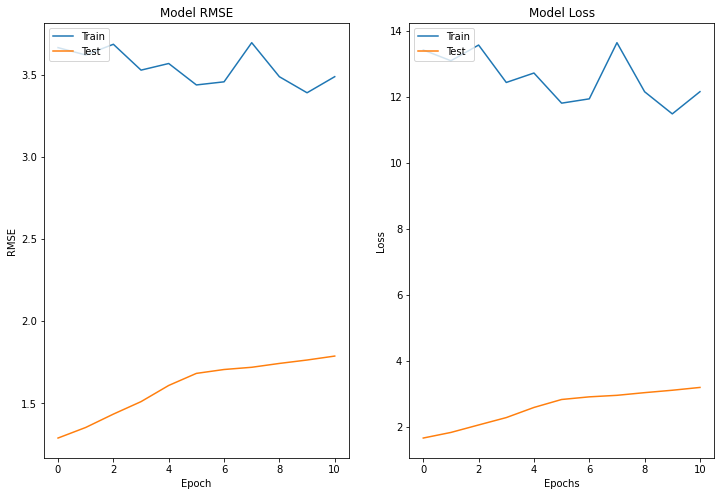

5/5 [==============================] - 3s 440ms/step


<ipython-input-15-9e032a6d7b88>:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_hat = (y_hat_tmp > thresh).astype(np.int)     # cast 0 or 1 to y_hat values


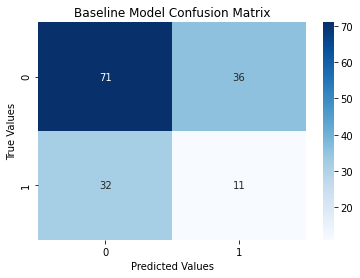

              precision    recall  f1-score   support

           0       0.69      0.66      0.68       107
           1       0.23      0.26      0.24        43

    accuracy                           0.55       150
   macro avg       0.46      0.46      0.46       150
weighted avg       0.56      0.55      0.55       150



In [44]:
evaluate_model(history, model, test)